In [2]:

import os
import random
import time

import dill as pickle
import numpy as np
import torch
from torch.distributions import Categorical
from tqdm import tqdm

from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from visualization import Visu
from subpo import calculate_submodular_reward, compute_subpo_advantages

workspace = "NM"

In [3]:

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 7, "y": 14},
        "horizon": 40,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": "env_data.pkl",
        "cov_module": "Matern",
        "stochasticity": 0.0,
        "domains": "two_room"
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.03,
        "epochs": 500,
        "lr": 0.01
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 300
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_1" 

params['env']['num'] = 1
# start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="code-" + params["env"]["node_weight"],
#     mode=params["visu"]["wb"],
#     config=params
# )

epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)
    
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])
# plt, fig = visu.stiener_grid( items_loc=env.items_loc, init=34)
# wandb.log({"chart": wandb.Image(fig)})
# plt.close()
# Hori_TransitionMatrix = torch.zeros(node_size*H, node_size*H)
# for node in env.horizon_transition_graph.nodes:
#     connected_edges = env.horizon_transition_graph.edges(node)
#     for u, v in connected_edges:
#         Hori_TransitionMatrix[u[0]*node_size+u[1], v[0]*node_size + v[1]] = 1.0
env.get_horizon_transition_matrix()
# policy = Policy(TransitionMatrix=TransitionMatrix, Hori_TransitionMatrix=Hori_TransitionMatrix, ActionTransitionMatrix=env.Hori_ActionTransitionMatrix[:, :, :, 0],
#                 agent_param=params["agent"], env_param=params["env"])


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001]


In [4]:
def select_cell_from_archive(archive):
    """
    Select a cell from the archive for exploration.
    Cells with the fewest selection counts are prioritized.
    """
    if not archive:
        return None, None

    # Find the minimum selection count
    min_times_selected = float('inf')
    for cell_id in archive:
        if archive[cell_id]['times_selected'] < min_times_selected:
            min_times_selected = archive[cell_id]['times_selected']
    
    # Find all cells with the minimum selection count
    least_visited_cells = []
    for cell_id in archive:
        if archive[cell_id]['times_selected'] == min_times_selected:
            least_visited_cells.append(cell_id)
            
    #  Randomly select one of these cells
    selected_cell_id = random.choice(least_visited_cells)
    
    return selected_cell_id, archive[selected_cell_id]

def sample_excellent_trajectories(filepath="go_explore_archive_spacetime.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [5]:
# 範例1：獲取獎勵最高的 20 條軌跡
print("--- 範例 1: 採樣 Top 20 ---")
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=11)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這300條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

# 範例2：獲取獎勵排名前 5% 的軌跡
print("--- 範例 2: 採樣 Top 5% ---")
top_5_percent_trajectories = sample_excellent_trajectories(method='top_p', p=0.05)
if top_5_percent_trajectories:
    # 打印其中一條軌跡的詳細信息以供檢查
    sample_traj_data = top_5_percent_trajectories[0]
    print(f"抽樣檢查最好的一條軌跡：獎勵={sample_traj_data['reward']}, 長度={len(sample_traj_data['states'])}\n")

# 範例3：獲取所有獎勵值大於等於 45 的軌跡
print("--- 範例 3: 採樣獎勵 >= 45 的軌跡 ---")
high_reward_trajectories = sample_excellent_trajectories(method='threshold', threshold=68)
if high_reward_trajectories:
    print(f"所有高分軌跡的平均獎勵為: {np.mean([d['reward'] for d in high_reward_trajectories]):.2f}\n")


--- 範例 1: 採樣 Top 20 ---
Error: Archive file not found 'go_explore_archive_spacetime.pkl'
--- 範例 2: 採樣 Top 5% ---
Error: Archive file not found 'go_explore_archive_spacetime.pkl'
--- 範例 3: 採樣獎勵 >= 45 的軌跡 ---
Error: Archive file not found 'go_explore_archive_spacetime.pkl'


In [6]:
#基于embedding的模仿学习

import torch
import torch.nn.functional as F  # 这里导入 F
import torch.nn as nn

class TemporalStateEncoder(nn.Module):
    def __init__(self, num_states=98, embed_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_states, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim)

    def forward(self, state_seq):
        indices = [i for i in state_seq if i >= 0]
        if not indices:
            return torch.zeros(self.lstm.hidden_size)

        input_emb = self.embedding(torch.tensor(indices).long()).unsqueeze(1)  # [T, 1, D]
        _, (h_n, _) = self.lstm(input_emb)
        return h_n.squeeze(0).squeeze(0)  # [hidden_dim]

def encode_temporal_state(state_seq, embed_table):
    """
    输入: state_seq: Tensor[H]，如 [34, 33, -1, ..., -1]
    输出: Tensor[embed_dim]，嵌入向量
    """
    indices = [i for i in state_seq if i >= 0]  # 去除 -1
    if not indices:
        return torch.zeros(embed_table.embedding_dim)
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    embeds = embed_table(indices_tensor)
    return embeds.mean(dim=0)
def encode_temporal_state2(state_seq, encoder):
    return encoder(state_seq)

def submodular_selector_temporal(trajectories, embed_table,temporal_encoder, budget=50, lambda_div=0.5, per_traj_limit=True):
    """
    改进版子模选择器：
    - 使用欧几里得距离作为 diversity 惩罚项
    - 可选启用：每条轨迹最多选一个状态（保证轨迹多样性）
    """
    state_vectors = []
    action_labels = []
    traj_ids = []

    for traj_id, traj in enumerate(trajectories):
        states = [int(s.item()) for s in traj['states']]
        actions = traj['actions']
        for t, action in enumerate(actions):
            temporal_state = [-1]*40
            for h in range(t+1):
                temporal_state[h] = states[h]
            temporal_tensor = torch.tensor(temporal_state, dtype=torch.long)
            # encoded = encode_temporal_state(temporal_tensor, embed_table) # 使用嵌入表编码
            # temporal_encoder = TemporalStateEncoder() #使用lstm+embedding编码
            vec = encode_temporal_state2(temporal_tensor, temporal_encoder)
            state_vectors.append(vec.detach())
            action_labels.append(action)
            traj_ids.append(traj_id)

    print(f"Total states collected: {len(state_vectors)}")
    all_states = torch.stack(state_vectors)
    all_actions = torch.tensor(action_labels, dtype=torch.long)
    traj_ids = torch.tensor(traj_ids)

    selected_indices = []
    selected_vectors = []
    selected_trajs = set()

    for _ in range(min(budget, len(all_states))):
        best_score, best_idx = -float("inf"), -1

        for i in range(len(all_states)):
            if i in selected_indices:
                continue
            if per_traj_limit and traj_ids[i].item() in selected_trajs:
                continue

            candidate = all_states[i].unsqueeze(0)
            reward = torch.abs(candidate).mean().item()

            if selected_vectors:
                selected_tensor = torch.stack(selected_vectors)
                sims = ((candidate - selected_tensor)**2).sum(dim=1)  # Euclidean squared
                diversity_penalty = -sims.mean().item()  # maximize distance
            else:
                diversity_penalty = 0

            score = reward + lambda_div * diversity_penalty

            if score > best_score:
                best_score = score
                best_idx = i

        if best_idx == -1:
            break

        selected_indices.append(best_idx)
        selected_vectors.append(all_states[best_idx])
        selected_trajs.add(traj_ids[best_idx].item())

    return all_states[selected_indices], all_actions[selected_indices],all_states,all_actions

In [7]:
embed_dim = 16
num_states = 98
elite_trajectories_data_1 = sample_excellent_trajectories(
        filepath="go_explore_archive_spacetime.pkl", 
        method='top_n', 
        n=11)
elite_trajectories_data_2 = sample_excellent_trajectories(
        filepath="go_explore_archive_spacetime_.pkl", 
        method='top_n', 
        n=11)
elite_trajectories_data=elite_trajectories_data_1 + elite_trajectories_data_2
embed_table = torch.nn.Embedding(num_states, 16)
temporal_encoder = TemporalStateEncoder()
print(embed_table)
selected_states, selected_actions, all_states,all_actions = submodular_selector_temporal(
    trajectories=elite_trajectories_data[:],
    embed_table=embed_table,
    temporal_encoder=temporal_encoder,
    budget=500,
    lambda_div=2.0,
    per_traj_limit=True
)
# print(len(selected_states))


Error: Archive file not found 'go_explore_archive_spacetime.pkl'
方法: Top-N。從 2312 條軌跡中篩選出最好的 11 條。
Embedding(98, 16)
Total states collected: 428


In [10]:
def expand_trajectory_states(trajectory_states, H):
    """
    将轨迹状态按照 append_state 的方式进行拓展
    
    Args:
        trajectory_states: 轨迹中的状态列表
        H: 时间范围参数
        
    Returns:
        expanded_states: 拓展后的状态列表
    """
    expanded_states = []
    
    # 模拟原始代码中的 mat_state 构建过程
    mat_state = []
    
    for i, state in enumerate(trajectory_states):
        mat_state.append(state)
        
        # 对于除了最后一个状态外的所有状态，都进行 append_state 拓展
        if i < H - 1:
            # 使用 append_state 函数进行状态拓展
            batch_state = append_state(mat_state, H-1)
            expanded_states.append(batch_state)
        else:
            expanded_states.append(expanded_states[-1])  # 最后一个状态不需要拓展，直接重复最后一个状态
    
    return expanded_states

# # 使用示例：拓展最佳轨迹的状态
# H = params["env"]["horizon"]  # 使用环境参数中的 horizon


    
# trajectory_states=top_20_trajectories[10]['states']
# expanded_trajectory_states = expand_trajectory_states(trajectory_states, H)

# print(f"原始轨迹状态数量: {len(trajectory_states)}")
# print(f"拓展后状态数量: {len(expanded_trajectory_states)}")

# # 查看拓展后的第一个状态的形状
# if expanded_trajectory_states:
#     print(f"拓展后第一个状态的形状: {expanded_trajectory_states[0].shape}")
# expanded_trajectory_states[-2],expanded_trajectory_states[-1]

In [11]:
expert_s=[]
expert_a=[]
for traj_i in elite_trajectories_data:
    expert_s.extend(np.array(expand_trajectory_states(traj_i['states'],H)[:-1]).squeeze())
    expert_a.extend(np.array(traj_i['actions']))
expert_s = np.array(expert_s)
expert_a = np.array(expert_a)


In [50]:

#策略网络训练模块
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class EmbeddingBehaviorClone:
        def __init__(self, state_dim, hidden_dim, action_dim, lr,device='cpu'):
            self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(device)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
            
        def learn(self, batch_states, batch_actions, total_loss):
            
            logits = self.policy(batch_states)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, batch_actions)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            return total_loss
        
        def predict_action_batch_sample(self, state_batch):
            if state_batch.dim() == 1:
                state_batch = state_batch.unsqueeze(0)
            with torch.no_grad():
                logits = self.policy(state_batch)
                probs = torch.softmax(logits, dim=1)
                actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
            return actions, probs.tolist()
        


def trajectory_to_temporal_states(batch_trajectory, temporal_encoder):
    """
    输入:
        batch_trajectory: Tensor[B, 40]
        temporal_encoder: TemporalStateEncoder 实例
    输出:
        Tensor[B, D]  # 每个轨迹编码后的向量
    """
    batch_embeddings = []
    for traj in batch_trajectory:
        traj = traj.tolist()
        vec = encode_temporal_state2(traj, temporal_encoder).detach()
        batch_embeddings.append(vec)
    return torch.stack(batch_embeddings)  # [B, D]

def predict_action_batch_sample(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的采样动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
    return actions, probs.tolist()

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

def train_policy_network(states, actions, num_actions, epochs=50, batch_size=64, lr=1e-3):
    print("Training policy network with states shape:", states.shape, "and actions shape:", actions.shape)
    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PolicyNetwork(states.size(1), hidden_dim=64, output_dim=num_actions)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    loss_returns=[]

    for epoch in range(epochs):
        total_loss = 0
        an=0
        for batch_states, batch_actions in loader:
            if an>0:
                break

            logits = model(batch_states)
            loss = criterion(logits, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            an+=1
        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}, len(loader): {len(loader)}")
    return model,

class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions).view(-1, 1)
        a=self.policy(states)
        b=a.gather(1, actions)
        log_probs = torch.log(b)
        bc_loss = torch.mean(-log_probs)  # 最大似然估计
        
        loss = bc_loss.item()

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()
        
        return loss

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

def test_agent_BC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        probs = agent.policy(batch_state)
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions.cpu())
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return
    

def test_agent_EBC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        temporal_states = trajectory_to_temporal_states(batch_state, temporal_encoder)
        actions, prob = agent.predict_action_batch_sample(temporal_states)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return

def test_agent_EBC2(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, h_iter+1).long()
        logits = agent.model(batch_state)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return

In [51]:
import torch
import torch.nn as nn
import os

class ModelHandler:
    """
    An external utility class dedicated to handling model saving and loading.
    """
    
    @staticmethod
    def save(agent, file_path):
        """
        Saves the policy network and optimizer state of an agent to a file.

        :param agent: The agent object to save (e.g., an instance of EmbeddingBehaviorClone).
        :param file_path: The path to save the file (e.g., "my_model.pth").
        """
        print(f"Saving model to {file_path} using external handler...")
        # Ensure the agent object has 'policy' and 'optimizer' attributes
        if not hasattr(agent, 'policy') or not hasattr(agent, 'optimizer'):
            print("Error: The provided agent object is missing 'policy' or 'optimizer' attributes.")
            return
            
        checkpoint = {
            'model_state_dict': agent.policy.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
        }
        torch.save(checkpoint, file_path)
        print("Model saved successfully. ✅")
        
    @staticmethod
    def save_encoder(model: nn.Module, file_path: str):
        """
            Directly saves the model's state_dict.
    
            :param model: The nn.Module model to save.
            :param file_path: The save path.
        """
        print(f"Saving model to {file_path} ...")
        torch.save(model.state_dict(), file_path)
        print("Model saved successfully. ✅")

    @staticmethod
    def load(agent, file_path,device='cpu'):
        """
        Loads the state from a file into a specified agent.

        :param agent: The target agent object to load the weights into.
        :param file_path: The path to the model file.
        """
        if not os.path.exists(file_path):
            print(f"Error: Model file '{file_path}' not found. Skipping load.")
            return

        print(f"Loading model from {file_path} using external handler...")
        if not hasattr(agent, 'policy') or not hasattr(agent, 'optimizer'):
            print("Error: The provided agent object is missing 'policy' or 'optimizer' attributes.")
            return
            
        # Use the agent's own 'device' attribute to ensure loading to the correct device
        checkpoint = torch.load(file_path, map_location=device)
        
        agent.policy.load_state_dict(checkpoint['model_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # After loading, set the model to evaluation mode
        agent.policy.eval()
        
        print("Model loaded successfully. ✅")
        
    @staticmethod
    def load_encoder(model: nn.Module, file_path: str):
        """
        Loads a state_dict into the model.

        :param model: The target model to load the weights into.
        :param file_path: The path to the model file.
        """
        if not os.path.exists(file_path):
            print(f"Error: Model file '{file_path}' not found.")
            return

        print(f"Loading model from {file_path} ...")
        # Get the device the model is currently on
        device = next(model.parameters()).device
        
        # Load the state_dict
        state_dict = torch.load(file_path, map_location=device)
        model.load_state_dict(state_dict)
        
        # Set to evaluation mode after loading
        model.eval()
        print("Model loaded successfully. ✅")

In [52]:
#test training time ebc
# model = train_policy_network(all_states, all_actions,epochs=50000, num_actions=5)
n_iterations = 30000
batch_size = 64
hidden_dim= 128
action_dim = 5
lr = 1e-3


In [53]:
import importlib
import ebcnet
importlib.reload(ebcnet)

<module 'ebcnet' from '/Users/zhy/Documents/GitHub/non-additive-RL/ebcnet.py'>

In [ ]:
#test training time ebc lose and score
from ebcnet import EndToEndBehaviorCloning
ebc_test_returns = []
state_dim_ebc=all_states.size(1)

raw_sequences = []
corresponding_actions = []

print("正在从专家轨迹构建 (序列, 动作) 数据对...")
for traj in elite_trajectories_data:
    states = [int(s.item()) for s in traj['states']]
    actions = traj['actions']
    
    # 轨迹中的每一步都是一个训练样本
    for t in range(len(actions)):
        # 构造当前时间步 t 的历史状态序列
        history_sequence = []
        current_history = states[:t+1]
        history_sequence[:len(current_history)] = current_history
        
        raw_sequences.append(history_sequence)
        corresponding_actions.append(actions[t])

print(f"数据对构建完成，共 {len(raw_sequences)} 个样本。")
sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=64)

# 注意：我们传递的是原始序列列表，而不是一个大的张量
batch_sequences = [raw_sequences[i] for i in sample_indices]

actions_tensor = torch.tensor(corresponding_actions, dtype=torch.long)
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ebc_agent = EndToEndBehaviorCloning(
    num_states=900, 
    embed_dim=16, 
    encoder_hidden_dim=32, 
    policy_hidden_dim=128, 
    action_dim=5, 
    lr=1e-3,
    device=device
)


with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=batch_size)
        
        batch_sequences = [raw_sequences[i] for i in sample_indices]
        batch_actions = actions_tensor[sample_indices]
    
        loss=ebc_agent.learn(batch_sequences, batch_actions)
        if (i + 1) % 20 == 0:
            current_return = test_agent_EBC2(ebc_agent, env,100)
            ebc_test_returns.append(current_return)
            pbar.set_postfix({'return': '%.3f' % (current_return)})
        pbar.update(1)

正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 428 个样本。


progress bar: 100%|██████████| 30000/30000 [35:03<00:00, 14.26it/s, return=68.000]


In [56]:
#test training time bc lose and score
bc_test_returns = []
bc_loss_returns = []

state_dim_bc = H-1
bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
        loss=bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
        bc_loss_returns.append(loss)
        if (i + 1) % 20 == 0:
            current_return = test_agent_BC(bc_agent, env, 100)
            bc_test_returns.append(current_return)
        pbar.update(1)



progress bar: 100%|██████████| 30000/30000 [00:17<00:00, 1680.32it/s]


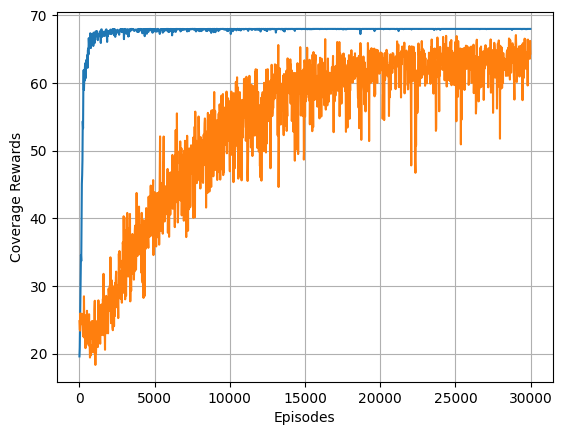

In [57]:
import pickle
import matplotlib.pyplot as plt

# 对数据进行采样，x轴按步长20显示
episodes_ebc = np.arange(len(ebc_test_returns)) * 20
episodes_bc = np.arange(len(bc_test_returns)) * 20

plt.plot(episodes_ebc, ebc_test_returns, label='SGE-EIL')
plt.plot(episodes_bc, bc_test_returns, label='SGE-IL')
plt.xlabel('Episodes')
plt.ylabel('Coverage Rewards')
plt.title('')
# plt.legend()  # 显示图例
plt.grid(True)
plt.show()

In [58]:
import pickle

# 保存数据到pickle文件
data_to_save = {
    'ebc_test_returns': ebc_test_returns,
    'bc_test_returns': bc_test_returns
}

# 保存为pickle文件
with open('two_room_98_data/two_room_98_training_results_1.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"数据已保存到 two_room_98_data/two_room_98_training_results_1.pkl")
print(f"EBC测试回报数量: {len(ebc_test_returns)}")
print(f"BC测试回报数量: {len(bc_test_returns)}")

数据已保存到 two_room_98_data/two_room_98_training_results_1.pkl
EBC测试回报数量: 1500
BC测试回报数量: 1500


In [ ]:
# 加载数据
# with open('two_room_98_training_results_0.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
    
# ebc_test_returns = loaded_data['ebc_test_returns']
# bc_test_returns = loaded_data['bc_test_returns']

In [59]:
training_epochs=2

In [60]:
#test training time ebc lose and score
from ebcnet import EndToEndBehaviorCloning
while(training_epochs<5):
    ebc_test_returns = []
    state_dim_ebc=all_states.size(1)

    raw_sequences = []
    corresponding_actions = []

    print("正在从专家轨迹构建 (序列, 动作) 数据对...")
    for traj in elite_trajectories_data:
        states = [int(s.item()) for s in traj['states']]
        actions = traj['actions']
        
        # 轨迹中的每一步都是一个训练样本
        for t in range(len(actions)):
            # 构造当前时间步 t 的历史状态序列
            history_sequence = []
            current_history = states[:t+1]
            history_sequence[:len(current_history)] = current_history
            
            raw_sequences.append(history_sequence)
            corresponding_actions.append(actions[t])

    print(f"数据对构建完成，共 {len(raw_sequences)} 个样本。")
    sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=64)

    # 注意：我们传递的是原始序列列表，而不是一个大的张量
    batch_sequences = [raw_sequences[i] for i in sample_indices]

    actions_tensor = torch.tensor(corresponding_actions, dtype=torch.long)
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ebc_agent = EndToEndBehaviorCloning(
        num_states=900, 
        embed_dim=16, 
        encoder_hidden_dim=32, 
        policy_hidden_dim=128, 
        action_dim=5, 
        lr=1e-3,
        device=device
    )


    with tqdm(total=n_iterations, desc="progress bar") as pbar:
        for i in range(n_iterations):
            sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=batch_size)
            
            batch_sequences = [raw_sequences[i] for i in sample_indices]
            batch_actions = actions_tensor[sample_indices]
        
            loss=ebc_agent.learn(batch_sequences, batch_actions)
            if (i + 1) % 20 == 0:
                current_return = test_agent_EBC2(ebc_agent, env,100)
                ebc_test_returns.append(current_return)
                pbar.set_postfix({'return': '%.3f' % (current_return)})
            pbar.update(1)
    #test training time bc lose and score
    bc_test_returns = []
    bc_loss_returns = []

    state_dim_bc = H-1
    bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
    with tqdm(total=n_iterations, desc="progress bar") as pbar:
        for i in range(n_iterations):
            sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
            loss=bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
            bc_loss_returns.append(loss)
            if (i + 1) % 20 == 0:
                current_return = test_agent_BC(bc_agent, env, 100)
                bc_test_returns.append(current_return)
            pbar.update(1)

    # 保存数据到pickle文件
    data_to_save = {
        'ebc_test_returns': ebc_test_returns,
        'bc_test_returns': bc_test_returns
    }

    # 保存为pickle文件
    with open('two_room_98_data/two_room_98_training_results_{training_epochs}.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)

    print(f"数据已保存到 two_room_98_data/two_room_98_training_results_{training_epochs}.pkl")
    print(f"EBC测试回报数量: {len(ebc_test_returns)}")
    print(f"BC测试回报数量: {len(bc_test_returns)}")
    training_epochs+=1

正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 428 个样本。


progress bar: 100%|██████████| 30000/30000 [00:16<00:00, 1809.85it/s]


数据已保存到 two_room_98_data/two_room_98_training_results_2.pkl
EBC测试回报数量: 1500
BC测试回报数量: 1500
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 428 个样本。


progress bar: 100%|██████████| 30000/30000 [00:16<00:00, 1823.34it/s]


数据已保存到 two_room_98_data/two_room_98_training_results_3.pkl
EBC测试回报数量: 1500
BC测试回报数量: 1500
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 428 个样本。


progress bar: 100%|██████████| 30000/30000 [00:16<00:00, 1829.13it/s]

数据已保存到 two_room_98_data/two_room_98_training_results_4.pkl
EBC测试回报数量: 1500
BC测试回报数量: 1500


In [61]:
# 修改热力图函数，将障碍物用棕色表示
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

def visu_heatmap_with_obstacles(self, visit_frequency=None, path=None, title="Visit Frequency Heatmap"):
    """
    可视化热力图，显示访问频率或值分布，障碍物用棕色表示
    
    Args:
        visit_frequency: 字典或数组，包含每个格子的访问频率或值
        path: 可选的路径数据，格式为 [(t, s), ...]
        title: 图表标题
    """
    f, ax = plt.subplots(figsize=(self.x_shape, self.y_shape))
    
    # 创建热力图数据矩阵
    heatmap_data = np.zeros((self.y_shape, self.x_shape))
    obstacle_mask = np.zeros((self.y_shape, self.x_shape), dtype=bool)
    
    # 检测障碍物
    if hasattr(env, 'Hori_ActionTransitionMatrix') and env.Hori_ActionTransitionMatrix is not None:
        for cell in range(self.x_shape * self.y_shape):
            is_obstacle = True
            for action in range(env.action_dim):
                if env.Hori_ActionTransitionMatrix[cell, cell, action] != 1.0:
                    is_obstacle = False
                    break
            if is_obstacle:
                x_coord = cell % self.x_shape
                y_coord = int(cell / self.x_shape)
                obstacle_mask[y_coord, x_coord] = True
    
    # 填充访问频率数据
    if visit_frequency is not None:
        if isinstance(visit_frequency, dict):
            for key, value in visit_frequency.items():
                if isinstance(key, tuple):
                    s = key[1] if len(key) > 1 else key[0]
                else:
                    s = key
                x_coord = s % self.x_shape
                y_coord = int(s / self.x_shape)
                if 0 <= y_coord < self.y_shape and 0 <= x_coord < self.x_shape:
                    heatmap_data[y_coord, x_coord] += value
        elif isinstance(visit_frequency, (list, np.ndarray)):
            if len(visit_frequency) == self.x_shape * self.y_shape:
                heatmap_data = np.array(visit_frequency).reshape(self.y_shape, self.x_shape)
    
    # 创建自定义颜色映射
    # 对于障碍物，我们将使用棕色
    display_data = heatmap_data.copy()
    
    # 先绘制基础热力图
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='equal', origin='lower', 
                   interpolation='nearest', alpha=0.8)
    
    # 在障碍物位置叠加棕色
    obstacle_data = np.ma.masked_where(~obstacle_mask, np.ones_like(heatmap_data))
    ax.imshow(obstacle_data, cmap='copper', aspect='equal', origin='lower', 
              interpolation='nearest', alpha=0.9, vmin=0, vmax=1)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Visit Frequency', rotation=270, labelpad=15)
    
    # 设置网格
    ax.set_xticks(np.arange(-0.5, self.x_shape, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, self.y_shape, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.0, alpha=0.7)
    
    # 设置主要刻度
    ax.set_xticks(np.arange(0, self.x_shape, 1))
    ax.set_yticks(np.arange(0, self.y_shape, 1))
    
    # 在每个格子中显示数值或障碍物标记
    for i in range(self.y_shape):
        for j in range(self.x_shape):
            if obstacle_mask[i, j]:
                # 障碍物显示 
                ax.text(j, i, '', ha="center", va="center", 
                       color="white", fontweight='bold', fontsize=12)
            elif heatmap_data[i, j] > 0:
                # 访问频率数值
                text_color = "white" if heatmap_data[i, j] < heatmap_data.max()/2 else "black"
                ax.text(j, i, f'{int(heatmap_data[i, j])}',
                       ha="center", va="center", 
                       color=text_color, fontweight='bold')
    
    # 如果有路径，绘制路径
    if path is not None:
        x_path = []
        y_path = []
        for cell in path:
            if isinstance(cell, tuple):
                cell_pos = cell[1] if len(cell) > 1 else cell[0]
            else:
                cell_pos = cell
            x_path.append(cell_pos % self.x_shape)
            y_path.append(int(cell_pos / self.x_shape))
        
        # 绘制路径线
        if len(x_path) > 1:
            ax.plot(x_path, y_path, 'r-', linewidth=3, alpha=0.8, label='Path')
        
        # 标记起点和终点
        if len(x_path) > 0:
            ax.plot(x_path[0], y_path[0], '*', color='orange', markersize=15, 
                   markeredgecolor='black', markeredgewidth=1, label='Start')
            if len(x_path) > 1:
                ax.plot(x_path[-1], y_path[-1], '*', color='lime', markersize=15,
                       markeredgecolor='black', markeredgewidth=1, label='End')
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # 设置标题和标签
    ax.set_title(f"{title}\nAverage Return {self.ret:.2f}")
    ax.set_xlim(-0.5, self.x_shape-0.5)
    ax.set_ylim(-0.5, self.y_shape-0.5)
    
    # 设置坐标轴标签
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    plt.tight_layout()
    self.iter += 1
    return plt, f

def visu_state_visits_with_obstacles(self, states_list, path=None):
    """
    根据状态列表创建访问频率热力图，包含障碍物显示
    
    Args:
        states_list: 状态列表，可以是 [s1, s2, s3, ...] 或 [tensor1, tensor2, ...]
        path: 可选的路径数据
    """
    # 统计每个状态的访问次数
    visit_counts = {}
    
    for state in states_list:
        if isinstance(state, torch.Tensor):
            state_val = state.item()
        else:
            state_val = state
            
        if state_val in visit_counts:
            visit_counts[state_val] += 1
        else:
            visit_counts[state_val] = 1
    
    return self.visu_heatmap_with_obstacles(visit_counts, path, "State Visit Frequency")

# 动态添加新方法到 Visu 类
Visu.visu_heatmap_with_obstacles = visu_heatmap_with_obstacles
Visu.visu_state_visits_with_obstacles = visu_state_visits_with_obstacles

print("带障碍物显示的热力图功能已成功添加到 Visu 类！")

带障碍物显示的热力图功能已成功添加到 Visu 类！


In [62]:
def test_agent_EBC_2(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, h_iter+1).long()
        logits = agent.model(batch_state)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return, mat_state

x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001]
使用了前20条轨迹，总访问状态数: 4000


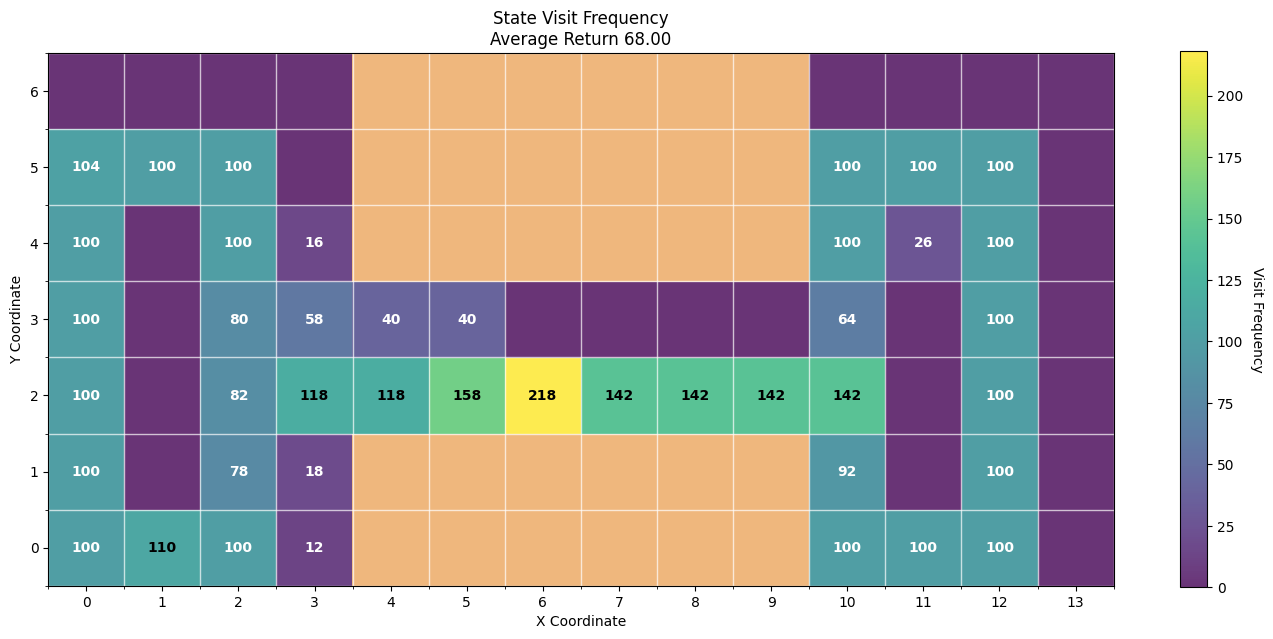

In [63]:
# 测试带障碍物的热力图功能

# 创建可视化对象
visu = Visu(env_params=params["env"])

mat_return, mat_states = test_agent_EBC_2(ebc_agent, env,100)
all_states = []
# 将所有状态从 mat_states 中提取出来
for traj in mat_states:
    all_states.extend(traj)

# 设置返回值
visu.path_return(mat_return)

print(f"使用了前20条轨迹，总访问状态数: {len(all_states)}")

# 创建带障碍物的访问频率热力图
plt_heatmap, fig_heatmap = visu.visu_state_visits_with_obstacles(all_states)
plt_heatmap.show()

In [109]:

#评估函数
def evaluate_policy(model, states, actions):
    model.eval()
    with torch.no_grad():
        logits = model(states)
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == actions).float().mean().item()
    print(f"Evaluation Accuracy: {accuracy*100:.2f}%")
    return accuracy
#保存模型
def save_policy_model(model, filepath="policy_model.pt"):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")
#加载模型
def load_policy_model(filepath, input_dim, hidden_dim, output_dim):
    model = PolicyNetwork(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model
#状态预测函数
def predict_action(model, states_tensor):
    """
    state_tensor: shape [1, D] 或 [D]
    """
    model.eval()
    actions=[]
    probss=[]
    for i in range(len(states_tensor)):
        # if states_tensor[i] < 0:
        #     states_tensor[i] = 0
        state_tensor = states_tensor[i]
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        with torch.no_grad():
            logits = model(state_tensor)
            probs = torch.softmax(logits, dim=1)
            action = torch.argmax(probs, dim=1).item()
            actions.append(action)
            probss.append(probs.squeeze().tolist())
    return actions, probss

def predict_action_batch(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的预测动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.argmax(probs, dim=1).tolist()
    return actions, probs.tolist()




In [110]:
def trajectory_to_temporal_states(batch_trajectory, temporal_encoder):
    """
    输入:
        batch_trajectory: Tensor[B, 40]
        temporal_encoder: TemporalStateEncoder 实例
    输出:
        Tensor[B, D]  # 每个轨迹编码后的向量
    """
    batch_embeddings = []
    for traj in batch_trajectory:
        traj = traj.tolist()
        vec = encode_temporal_state2(traj, temporal_encoder).detach()
        batch_embeddings.append(vec)
    return torch.stack(batch_embeddings)  # [B, D]

In [146]:
new_agent = EmbeddingBehaviorClone(state_dim_ebc, hidden_dim, action_dim, lr, 'cpu')

# 使用 ModelHandler 将文件中的状态加载到这个新代理中
ModelHandler.load(agent=new_agent, file_path=model_save_path)
model=new_agent.policy

Loading model from EIL_model.pth using external handler...
Model loaded successfully. ✅


/var/folders/f_/r_s1rwfd2g16krlmf849196w0000gn/T/ipykernel_90046/1875666905.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_locat

In [148]:
temporal_encoder=TemporalStateEncoder()
ModelHandler.load_encoder(temporal_encoder, encoder_model_path)

Loading model from temporal_encoder.pth ...
Model loaded successfully. ✅


/var/folders/f_/r_s1rwfd2g16krlmf849196w0000gn/T/ipykernel_90046/1875666905.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path, map_locat